<a href="https://colab.research.google.com/github/dongzooo/Quant-with-py/blob/main/%EC%BA%94%EB%93%A4%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EB%B6%84%EC%84%9D/3%EB%B6%84%EB%B4%895%EC%9D%B4%ED%8F%89_%EB%B3%80%EA%B3%A1_%ED%86%B5%EA%B3%84%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 3분봉5이평변곡 시 1분봉 패턴분석

### 1. 데이터 불러오기 및 전처리

In [ ]:
# 폰트 설치 : 글자 깨지면 런타임 재실행
!pip install yfinance --quiet

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [1]:
import yfinance as yf
import pandas as pd
import datetime
from google.colab import files

import seaborn as sns
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import Logit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

# 유니코드에서  음수 부호설정
matplotlib.rc('axes', unicode_minus=False)

In [66]:
files.upload()

Saving ytd1MinData.csv to ytd1MinData.csv
Saving ytd3MinData.csv to ytd3MinData.csv


{'ytd1MinData.csv': b',0,1,2,3,4,5\r\n0,23-05-23 10:46:00,16820,16860,16820,16855,177630\r\n1,23-05-23 10:47:00,16855,16870,16855,16865,163617\r\n2,23-05-23 10:48:00,16865,16865,16830,16835,40141\r\n3,23-05-23 10:49:00,16835,16850,16830,16845,65251\r\n4,23-05-23 10:50:00,16850,16855,16830,16845,41720\r\n5,23-05-23 10:51:00,16845,16845,16835,16835,27286\r\n6,23-05-23 10:52:00,16835,16840,16830,16835,22842\r\n7,23-05-23 10:53:00,16835,16840,16830,16830,17811\r\n8,23-05-23 10:54:00,16825,16825,16820,16820,21713\r\n9,23-05-23 10:55:00,16820,16825,16810,16815,40301\r\n10,23-05-23 10:56:00,16815,16820,16810,16820,8956\r\n11,23-05-23 10:57:00,16815,16820,16810,16820,10140\r\n12,23-05-23 10:58:00,16820,16820,16800,16800,54524\r\n13,23-05-23 10:59:00,16800,16810,16795,16810,28373\r\n14,23-05-23 11:00:00,16810,16810,16800,16805,29954\r\n15,23-05-23 11:01:00,16805,16810,16795,16805,11571\r\n16,23-05-23 11:02:00,16805,16810,16800,16800,12109\r\n17,23-05-23 11:03:00,16800,16820,16800,16815,16577\r\

In [113]:
#14시50분 이후 데이터는 날리는 작업은 이평성 생성후 한다
target_time = pd.to_datetime("14:50:00", format="%H:%M:%S").strftime('%H:%M:%S')

df1Min = pd.read_csv("/content/ytd1MinData.csv")
df1Min = df1Min.drop(df1Min.columns[0], axis=1)
df1Min.columns = ['Timestamp', 'Open', 'High', 'Low', 'Close','Volume']
# df1Min['Timestamp'] = pd.to_datetime(df1Min['Timestamp'], format="%y-%m-%d %H:%M:%S")
# df1Min = df1Min[df1Min['Timestamp'].dt.strftime('%H:%M:%S') <= target_time]
# df1Min = df1Min.reset_index(drop=True)
df1Min.head()

df3Min = pd.read_csv("/content/ytd3MinData.csv")
df3Min = df3Min.drop(df3Min.columns[0], axis=1)
df3Min.columns = ['Timestamp', 'Open', 'High', 'Low', 'Close','Volume']
# df3Min['Timestamp'] = pd.to_datetime(df3Min['Timestamp'], format="%y-%m-%d %H:%M:%S")
# df3Min = df3Min[df3Min['Timestamp'].dt.strftime('%H:%M:%S') <= target_time]
# df3Min = df3Min.reset_index(drop=True)

df3Min.head()

,Timestamp,Open,High,Low,Close,Volume
0,23-05-16 13:12:00,15670,15680,15660,15680,33957
1,23-05-16 13:15:00,15670,15675,15660,15660,52079
2,23-05-16 13:18:00,15665,15680,15665,15680,19977
3,23-05-16 13:21:00,15680,15680,15665,15670,46640
4,23-05-16 13:24:00,15670,15680,15665,15680,10414


### 2. 분봉데이터 지표계산

#### 1) 3분봉 지표계산

In [114]:
# 3분봉 이평선 생성
df3Min['5MA'] = df3Min['Close'].rolling(window=5).mean()
# df3Min['Return'] = df3Min['Close'].pct_change() * 100
df3Min.head()
# df3Min['MA_Crossover'] = df3Min['Moving Average'].diff().shift(-1).fillna(0).apply(lambda x: 1 if x > 0 else -1 if x < 0 else 0)

,Timestamp,Open,High,Low,Close,Volume,5MA
0,23-05-16 13:12:00,15670,15680,15660,15680,33957,NaN
1,23-05-16 13:15:00,15670,15675,15660,15660,52079,NaN
2,23-05-16 13:18:00,15665,15680,15665,15680,19977,NaN
3,23-05-16 13:21:00,15680,15680,15665,15670,46640,NaN
4,23-05-16 13:24:00,15670,15680,15665,15680,10414,15674.0


In [133]:
#3분봉과 1분봉 시계열 시작 맞추기
df1Min['Timestamp'].iloc[0]
df3Min = df3Min[df3Min['Timestamp'] >= df1Min['Timestamp'].iloc[0]]
df3Min = df3Min.reset_index(drop=True)
df3Min

,Timestamp,Open,High,Low,Close,Volume,5MA,Profitable
0,2023-05-23 10:48:00,16865,16865,16830,16845,147112,16836.0,0
1,2023-05-23 10:51:00,16845,16845,16830,16830,67939,16833.0,0
2,2023-05-23 10:54:00,16825,16825,16810,16820,70970,16834.0,0
3,2023-05-23 10:57:00,16815,16820,16795,16810,93037,16834.0,0
4,2023-05-23 11:00:00,16810,16810,16795,16800,53634,16821.0,0
...,...,...,...,...,...,...,...,...
297,2023-05-25 12:45:00,16645,16650,16635,16645,29846,16637.0,0
298,2023-05-25 12:48:00,16645,16645,16610,16615,51695,16637.0,0
299,2023-05-25 12:51:00,16615,16620,16600,16605,258551,16630.0,0
300,2023-05-25 12:54:00,16605,16620,16595,16600,72102,16621.0,0


#### 2) 1분봉 지표계산

In [134]:
# 1분봉 이동평균선 계산
df1Min['3MA'] = df1Min['Close'].rolling(window=3).mean()
df1Min['5MA'] = df1Min['Close'].rolling(window=5).mean()
df1Min['10MA'] = df1Min['Close'].rolling(window=10).mean()
df1Min['20MA'] = df1Min['Close'].rolling(window=20).mean()
df1Min['60MA'] = df1Min['Close'].rolling(window=60).mean()

#우상향여부
df1Min['3MA우상향'] = df1Min['3MA'].pct_change()
df1Min['5MA우상향'] = df1Min['5MA'].pct_change()
df1Min['10MA우상향'] = df1Min['10MA'].pct_change()
df1Min['20MA우상향'] = df1Min['20MA'].pct_change()
df1Min['60MA우상향'] = df1Min['60MA'].pct_change()

df1Min['3MA우상향'] = df1Min['3MA우상향'].apply(lambda x: 1 if x > 0 else 0)
df1Min['5MA우상향'] = df1Min['5MA우상향'].apply(lambda x: 1 if x > 0 else 0)
df1Min['10MA우상향'] = df1Min['10MA우상향'].apply(lambda x: 1 if x > 0 else 0)
df1Min['20MA우상향'] = df1Min['20MA우상향'].apply(lambda x: 1 if x > 0 else 0)
df1Min['60MA우상향'] = df1Min['60MA우상향'].apply(lambda x: 1 if x > 0 else 0)

#거래이평선 계산
df1Min['2VMA'] = df1Min['Volume'].rolling(window=2).mean()
df1Min['5VMA'] = df1Min['Volume'].rolling(window=5).mean()
df1Min['10VMA'] = df1Min['Volume'].rolling(window=10).mean()
df1Min['20VMA'] = df1Min['Volume'].rolling(window=20).mean()
df1Min['60VMA'] = df1Min['Volume'].rolling(window=60).mean()

#현봉 전봉 거래량 비교
df1Min['VolumeChange'] = df1Min['Volume'].pct_change()

#데이터프레임 datetime으로 변경
df1Min['Timestamp'] = pd.to_datetime(df1Min['Timestamp'], format="%y-%m-%d %H:%M:%S")
df1Min

,Timestamp,Open,High,Low,Close,Volume,3MA,5MA,10MA,20MA,...,5MA우상향,10MA우상향,20MA우상향,60MA우상향,2VMA,5VMA,10VMA,20VMA,60VMA,VolumeChange
0,2023-05-23 10:46:00,16820,16860,16820,16855,177630,NaN,NaN,NaN,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-05-23 10:47:00,16855,16870,16855,16865,163617,NaN,NaN,NaN,NaN,...,0,0,0,0,170623.5,NaN,NaN,NaN,NaN,-0.078889
2,2023-05-23 10:48:00,16865,16865,16830,16835,40141,16851.666667,NaN,NaN,NaN,...,0,0,0,0,101879.0,NaN,NaN,NaN,NaN,-0.754665
3,2023-05-23 10:49:00,16835,16850,16830,16845,65251,16848.333333,NaN,NaN,NaN,...,0,0,0,0,52696.0,NaN,NaN,NaN,NaN,0.625545
4,2023-05-23 10:50:00,16850,16855,16830,16845,41720,16841.666667,16849.0,NaN,NaN,...,0,0,0,0,53485.5,97671.8,NaN,NaN,NaN,-0.360623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894,2023-05-25 12:56:00,16605,16605,16595,16600,17226,16606.666667,16606.0,16614.0,16627.25,...,0,0,0,0,15946.5,66079.2,38416.9,23763.10,24738.233333,0.174473
895,2023-05-25 12:57:00,16600,16600,16585,16590,94818,16600.000000,16603.0,16608.5,16624.50,...,0,0,0,0,56022.0,69522.8,47716.6,27756.55,24980.350000,4.504354
896,2023-05-25 12:58:00,16595,16600,16590,16590,15423,16593.333333,16600.0,16605.5,16622.00,...,0,0,0,0,55120.5,36468.6,47253.1,28383.05,24134.716667,-0.837341
897,2023-05-25 12:59:00,16590,16590,16585,16585,81912,16588.333333,16595.0,16602.5,16619.25,...,0,0,0,0,48667.5,44809.2,53700.2,32224.00,23585.700000,4.311029


### 3. 변곡 시 1분봉 뷰 분석

#### 1) 수익나는 변곡시점 찾아 데이터프레임 생성

In [135]:
# 수익나는 변곡시점 찾는 알고리즘
def findInflection(n, df, col_name):
    turning_points = []
    start_num = n + 1
    for i in range(start_num, len(df)):
      buyPrice = 0
      # 변곡 발생
      if (df[col_name].iloc[i] > df[col_name].iloc[i - 1] <= df[col_name].iloc[i - 2]):
        buyPrice = df['Close'].iloc[i]
        targetPrice = buyPrice + (buyPrice*0.005)
        stopLossPrice = buyPrice - (buyPrice*0.005)
        #매수 시물레이션
        for j in range(i,len(df)) :
           # 손절 조건: 현봉저가가 전봉저가보다 낮아지면
          if df['Low'].iloc[j] < df['Low'].iloc[j-1] and df['Close'].iloc[j] <= stopLossPrice:
              break
          #익절조건
          elif df['Close'].iloc[j] >= targetPrice :
              turning_points.append(i)
              break
    return turning_points

In [136]:
#수익이나는 인덱스 조사
turning_points = findInflection(5,df3Min,"5MA")
#데이터프레임에 수익여부 넣기
df3Min_Infection = pd.DataFrame(columns=df3Min.columns)
df3Min_Infection = df3Min
df3Min_Infection['Profitable'] = 0

# 수익이 나는 경우에 해당하는 행의 'Profitable' 열 값을 1로 설정
df3Min_Infection.loc[turning_points, 'Profitable'] = 1
df3Min_Infection[df3Min_Infection['Profitable'] == 1]


#2시50분 이후 매매 기록 삭제
df3Min_Infection['Timestamp'] = pd.to_datetime(df3Min_Infection['Timestamp'], format="%y-%m-%d %H:%M:%S")
df3Min_Infection = df3Min_Infection[df3Min_Infection['Timestamp'].dt.strftime('%H:%M:%S') <= target_time]
df3Min_Infection = df3Min_Infection.reset_index(drop=True)
df3Min_Infection.tail()

# count = df3Min_Infection['Profitable'].value_counts()[1]
# print(count)

,Timestamp,Open,High,Low,Close,Volume,5MA,Profitable
273,2023-05-25 12:45:00,16645,16650,16635,16645,29846,16637.0,0
274,2023-05-25 12:48:00,16645,16645,16610,16615,51695,16637.0,0
275,2023-05-25 12:51:00,16615,16620,16600,16605,258551,16630.0,0
276,2023-05-25 12:54:00,16605,16620,16595,16600,72102,16621.0,0
277,2023-05-25 12:57:00,16600,16600,16585,16585,192153,16610.0,0


In [137]:
#1분봉 이동평균선
df1Min3ma = pd.DataFrame(columns=df1Min.columns)
turning_points = findInflection(3,df1Min,"3MA")
for i in turning_points:
  df1Min3ma = df1Min3ma._append(df1Min.iloc[i],ignore_index=True)

df1Min5ma = pd.DataFrame(columns=df1Min.columns)
turning_points = findInflection(5,df1Min,"5MA")
for i in turning_points:
  df1Min5ma = df1Min5ma._append(df1Min.iloc[i],ignore_index=True)

df1Min10ma = pd.DataFrame(columns=df1Min.columns)
turning_points = findInflection(10,df1Min,"10MA")
for i in turning_points:
  df1Min10ma = df1Min10ma._append(df1Min.iloc[i],ignore_index=True)

df1Min20ma = pd.DataFrame(columns=df1Min.columns)
turning_points = findInflection(20,df1Min,"20MA")
for i in turning_points:
  df1Min20ma = df1Min20ma._append(df1Min.iloc[i],ignore_index=True)

df1Min60ma = pd.DataFrame(columns=df1Min.columns)
turning_points = findInflection(60,df1Min,"60MA")
for i in turning_points:
  df1Min60ma = df1Min60ma._append(df1Min.iloc[i],ignore_index=True)

In [138]:
#1분봉 거래평균선
df1Min2vma = pd.DataFrame(columns=df1Min.columns)
turning_points = findInflection(2,df1Min,"2VMA")
for i in turning_points:
  df1Min2vma = df1Min2vma._append(df1Min.iloc[i],ignore_index=True)

df1Min5vma = pd.DataFrame(columns=df1Min.columns)
turning_points = findInflection(5,df1Min,"5VMA")
for i in turning_points:
  df1Min5vma = df1Min5vma._append(df1Min.iloc[i],ignore_index=True)

df1Min10vma = pd.DataFrame(columns=df1Min.columns)
turning_points = findInflection(10,df1Min,"10VMA")
for i in turning_points:
  df1Min10vma = df1Min10vma._append(df1Min.iloc[i],ignore_index=True)

df1Min20vma = pd.DataFrame(columns=df1Min.columns)
turning_points = findInflection(20,df1Min,"20VMA")
for i in turning_points:
  df1Min20vma = df1Min20vma._append(df1Min.iloc[i],ignore_index=True)

df1Min60vma = pd.DataFrame(columns=df1Min.columns)
turning_points = findInflection(60,df1Min,"60VMA")
for i in turning_points:
  df1Min60vma = df1Min60vma._append(df1Min.iloc[i],ignore_index=True)

#### 2) 3분봉 이평변곡 발생한 시간에 1분봉 뷰 적용

In [139]:
#이동평균선 변곡 발생시 값 추가
df3Min_Infection['3MA변곡'] = 0
df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min3ma['Timestamp']), '3MA변곡'] = 1

df3Min_Infection['5MA변곡'] = 0
df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min5ma['Timestamp']), '5MA변곡'] = 1

df3Min_Infection['10MA변곡'] = 0
df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min10ma['Timestamp']), '10MA변곡'] = 1

df3Min_Infection['20MA변곡'] = 0
df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min20ma['Timestamp']), '20MA변곡'] = 1

df3Min_Infection['60MA변곡'] = 0
df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min20ma['Timestamp']), '60MA변곡'] = 1

In [140]:
df1Min5ma.tail()

,Timestamp,Open,High,Low,Close,Volume,3MA,5MA,10MA,20MA,...,5MA우상향,10MA우상향,20MA우상향,60MA우상향,2VMA,5VMA,10VMA,20VMA,60VMA,VolumeChange
30,2023-05-24 14:03:00,16685,16690,16685,16690,10968,16683.333333,16685.0,16685.0,16687.75,...,1,0,0,1,7719.5,10450.8,13547.3,16058.35,11370.633333,1.453142
31,2023-05-24 15:01:00,16710,16710,16700,16705,3869,16708.333333,16703.0,16707.5,16721.00,...,1,0,0,1,18007.5,18248.2,14047.9,16245.70,20974.400000,-0.879643
32,2023-05-24 15:18:00,16655,16670,16655,16665,32861,16660.000000,16658.0,16666.5,16682.25,...,1,0,0,0,20770.5,13901.8,23121.8,26131.90,18517.950000,2.785829
33,2023-05-24 15:30:00,16680,16680,16680,16680,260937,16666.666667,16663.0,16663.5,16678.00,...,1,0,0,0,171711.0,79620.2,51325.7,41053.50,24185.133333,2.163448
34,2023-05-25 09:33:00,16705,16705,16700,16705,48529,16703.333333,16705.0,16712.0,16733.00,...,1,0,0,0,47527.5,66517.0,77799.7,71398.85,73999.383333,0.043051


In [141]:
#이동평균선 변곡 발생시
df3Min_Infection['2VMA변곡'] = 0
df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min2vma['Timestamp']), '2VMA변곡'] = 1

df3Min_Infection['5VMA변곡'] = 0
df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min5vma['Timestamp']), '5VMA변곡'] = 1

df3Min_Infection['10VMA변곡'] = 0
df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min10vma['Timestamp']), '10VMA변곡'] = 1

df3Min_Infection['20VMA변곡'] = 0
df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min20vma['Timestamp']), '20VMA변곡'] = 1

df3Min_Infection['60VMA변곡'] = 0
df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min20vma['Timestamp']), '60VMA변곡'] = 1

In [142]:
df3Min_Infection.head()

,Timestamp,Open,High,Low,Close,Volume,5MA,Profitable,3MA변곡,5MA변곡,10MA변곡,20MA변곡,60MA변곡,2VMA변곡,5VMA변곡,10VMA변곡,20VMA변곡,60VMA변곡
0,2023-05-23 10:48:00,16865,16865,16830,16845,147112,16836.0,0,0,0,0,0,0,0,0,0,0,0
1,2023-05-23 10:51:00,16845,16845,16830,16830,67939,16833.0,0,0,0,0,0,0,0,0,0,0,0
2,2023-05-23 10:54:00,16825,16825,16810,16820,70970,16834.0,0,0,0,0,0,0,0,0,0,0,0
3,2023-05-23 10:57:00,16815,16820,16795,16810,93037,16834.0,0,0,0,0,0,0,0,0,0,0,0
4,2023-05-23 11:00:00,16810,16810,16795,16800,53634,16821.0,0,0,0,0,0,0,0,0,0,0,0


In [143]:
#거래량이 전봉보다 현봉이 많을 때
df3Min_Infection['VolumeChange'] = 0
df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min.loc[df1Min['VolumeChange'] > 0, 'Timestamp']), 'VolumeChange'] = 1

# #1분봉 우상향 여부 추가
df3Min_Infection['3MA우상향'] = 0
df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min.loc[df1Min['3MA우상향'] > 0, 'Timestamp']), '3MA우상향'] = 1

df3Min_Infection['5MA우상향'] = 0
df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min.loc[df1Min['5MA우상향'] > 0, 'Timestamp']), '5MA우상향'] = 1

df3Min_Infection['10MA우상향'] = 0
df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min.loc[df1Min['10MA우상향'] > 0, 'Timestamp']), '10MA우상향'] = 1

df3Min_Infection['20MA우상향'] = 0
df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min.loc[df1Min['20MA우상향'] > 0, 'Timestamp']), '20MA우상향'] = 1

df3Min_Infection['60MA우상향'] = 0
df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min.loc[df1Min['60MA우상향'] > 0, 'Timestamp']), '60MA우상향'] = 1

# #불필요한 데이터 삭제
# df3Min_Infection.drop(labels=['Open','High','Low','Close'],axis=1,inplace=True)

#결측치 제거
df3Min_Infection.fillna(0, inplace=True)

df3Min_Infection.tail()

,Timestamp,Open,High,Low,Close,Volume,5MA,Profitable,3MA변곡,5MA변곡,...,5VMA변곡,10VMA변곡,20VMA변곡,60VMA변곡,VolumeChange,3MA우상향,5MA우상향,10MA우상향,20MA우상향,60MA우상향
273,2023-05-25 12:45:00,16645,16650,16635,16645,29846,16637.0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
274,2023-05-25 12:48:00,16645,16645,16610,16615,51695,16637.0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
275,2023-05-25 12:51:00,16615,16620,16600,16605,258551,16630.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
276,2023-05-25 12:54:00,16605,16620,16595,16600,72102,16621.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
277,2023-05-25 12:57:00,16600,16600,16585,16585,192153,16610.0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


### 4. 데이터 통계

In [146]:
df3Min_Infection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278 entries, 0 to 277
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Timestamp     278 non-null    datetime64[ns]
 1   Open          278 non-null    int64         
 2   High          278 non-null    int64         
 3   Low           278 non-null    int64         
 4   Close         278 non-null    int64         
 5   Volume        278 non-null    int64         
 6   5MA           278 non-null    float64       
 7   Profitable    278 non-null    int64         
 8   3MA변곡         278 non-null    int64         
 9   5MA변곡         278 non-null    int64         
 10  10MA변곡        278 non-null    int64         
 11  20MA변곡        278 non-null    int64         
 12  60MA변곡        278 non-null    int64         
 13  2VMA변곡        278 non-null    int64         
 14  5VMA변곡        278 non-null    int64         
 15  10VMA변곡       278 non-null    int64     

In [145]:
df_profitable_1.tail()

,Timestamp,Open,High,Low,Close,Volume,5MA,Profitable,3MA변곡,5MA변곡,...,5VMA변곡,10VMA변곡,20VMA변곡,60VMA변곡,VolumeChange,3MA우상향,5MA우상향,10MA우상향,20MA우상향,60MA우상향
154,2023-05-24 12:39:00,16635,16660,16635,16660,78112,16633.0,1,0,0,...,0,1,0,0,1,1,1,1,1,1
160,2023-05-24 12:57:00,16655,16675,16655,16665,26677,16658.0,1,1,1,...,0,0,0,0,0,1,1,1,1,1
164,2023-05-24 13:09:00,16660,16665,16655,16665,16231,16659.0,1,0,0,...,0,1,0,0,1,1,0,0,1,1
166,2023-05-24 13:15:00,16665,16685,16665,16685,54212,16664.0,1,1,0,...,0,0,0,0,0,1,1,1,1,1
178,2023-05-24 13:51:00,16690,16695,16690,16695,117430,16691.0,1,0,1,...,0,0,0,0,1,0,1,0,0,1


In [154]:
# df3Min_Infection.columns
# 필요한 컬럼 선택
columns = ['3MA변곡', '5MA변곡', '10MA변곡',
       '20MA변곡','60MA변곡', '2VMA변곡', '5VMA변곡', '10VMA변곡', '20VMA변곡','60VMA변곡', 'VolumeChange',
       '3MA우상향', '5MA우상향', '10MA우상향', '20MA우상향','60MA우상향']

# 'Profitable'이 1인 경우의 데이터프레임 추출
df_profitable_1 = df3Min_Infection[df3Min_Infection['Profitable'] == 1]
df_profitable_1 = df_profitable_1.reset_index(drop=True)
df_profitable_1

,Timestamp,Open,High,Low,Close,Volume,5MA,Profitable,3MA변곡,5MA변곡,...,5VMA변곡,10VMA변곡,20VMA변곡,60VMA변곡,VolumeChange,3MA우상향,5MA우상향,10MA우상향,20MA우상향,60MA우상향
0,2023-05-24 09:15:00,16690,16695,16675,16675,103592,16667.0,1,0,0,...,0,0,0,0,0,1,1,1,0,0
1,2023-05-24 10:24:00,16635,16665,16635,16660,59737,16644.0,1,1,0,...,1,0,0,0,1,1,1,1,0,0
2,2023-05-24 10:48:00,16655,16680,16655,16675,43940,16676.0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
3,2023-05-24 11:00:00,16655,16670,16645,16670,21623,16668.0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
4,2023-05-24 11:06:00,16670,16670,16655,16660,25391,16667.0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
5,2023-05-24 11:12:00,16660,16675,16660,16675,19516,16666.0,1,1,1,...,1,1,0,0,1,1,1,0,0,1
6,2023-05-24 12:12:00,16625,16630,16620,16630,44525,16611.0,1,0,0,...,0,0,1,1,1,1,1,1,0,0
7,2023-05-24 12:39:00,16635,16660,16635,16660,78112,16633.0,1,0,0,...,0,1,0,0,1,1,1,1,1,1
8,2023-05-24 12:57:00,16655,16675,16655,16665,26677,16658.0,1,1,1,...,0,0,0,0,0,1,1,1,1,1
9,2023-05-24 13:09:00,16660,16665,16655,16665,16231,16659.0,1,0,0,...,0,1,0,0,1,1,0,0,1,1


In [155]:
# 컬럼별로 퍼센트 계산
percentages = []
for column in columns:
    percentage = (df_profitable_1[column].sum() / df_profitable_1.shape[0]) * 100
    percentages.append(round(percentage,2))
# 결과를 데이터프레임으로 정리
result_df = pd.DataFrame({'Column': columns, 'Percentage(%)': percentages})
result_df = result_df.sort_values('Column').reset_index(drop=True)

# 결과 출력
result_df
result_df.sort_values(by='Percentage(%)', ascending=False)

,Column,Percentage(%)
10,5MA우상향,75.00
8,3MA우상향,66.67
15,VolumeChange,66.67
1,10MA우상향,50.00
4,20MA우상향,50.00
13,60MA우상향,50.00
3,20MA변곡,33.33
7,3MA변곡,33.33
12,60MA변곡,33.33
2,10VMA변곡,25.00


In [148]:
df3Min_Infection.columns

Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', '5MA',
       'Profitable', '3MA변곡', '5MA변곡', '10MA변곡', '20MA변곡', '60MA변곡', '2VMA변곡',
       '5VMA변곡', '10VMA변곡', '20VMA변곡', '60VMA변곡', 'VolumeChange', '3MA우상향',
       '5MA우상향', '10MA우상향', '20MA우상향', '60MA우상향'],
      dtype='object')

In [150]:
# Splitting the data into training and testing sets
X = df3Min_Infection.drop(['Profitable', 'Timestamp'], axis=1)
y = df3Min_Infection['Profitable']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  shuffle=False)

# Preprocessing: Scaling the independent variables
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluating the model
accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

# Calculating precision
precision = metrics.precision_score(y_test, y_pred)
print(f"Precision: {precision}")


Accuracy: 1.0
Precision: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [151]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### 5. 로지스틱 회귀분석

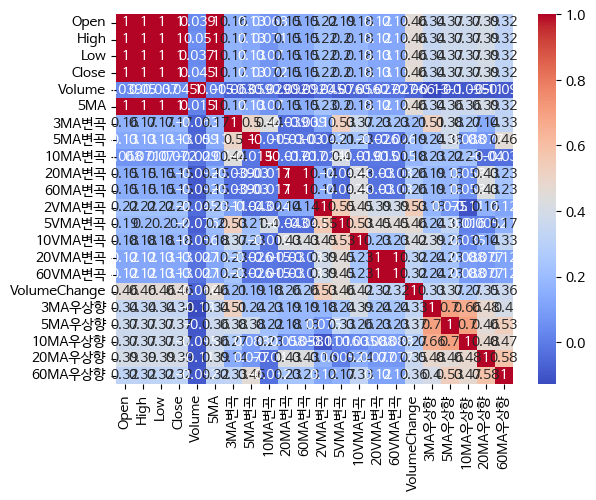

Accuracy: 0.625


In [103]:
# 데이터 전처리
X = df3Min_Infection.drop(['Profitable', 'Timestamp'], axis=1)
y = df3Min_Infection['Profitable']

# 언더샘플링을 통한 데이터 불균형 처리
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# 통계분석
# 변수간 상관관계 분석
correlation_matrix = pd.DataFrame(X_scaled, columns=X.columns).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

# Logistic Regression 모델 학습
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)

# 모델 평가
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)